# Explore US Bike Share Data

## Table of Contents
- [Introduction](#intro)
- [Posing Questions](#pose_questions)
- [Data Collection and Wrangling](#wrangling)
  - [Condensing the Trip Data](#condensing)
- [Exploratory Data Analysis](#eda)
  - [Statistics](#statistics)
  - [Visualizations](#visualizations)
- [Continuing The Analysis](#eda_continued)
- [Conclusion and Recommendations](#conclusions)

<a id='intro'></a>
## Introduction



Over the past decade, bicycle-sharing systems have been growing in number and popularity in cities across the world. Bicycle-sharing systems allow users to rent bicycles for short trips, typically 30 minutes or less. Thanks to the rise in information technologies, it is easy for a user of the system to access a dock within the system to unlock or return bicycles. These technologies also provide a wealth of data that can be used to explore how these bike-sharing systems are used.

In this project, I will perform an exploratory analysis on data provided by [Motivate](https://www.motivateco.com/), a bike-share system provider for many major cities in the United States. I will compare the system usage between three large cities: New York City, Chicago, and Washington, DC. I will also see if there are any differences within each system for those users that are registered, regular users and those users that are short-term, casual users.

<a id='pose_questions'></a>
## Posing Questions

Before looking at the bike sharing data, I will consider what kind of questions I might be able to answer with this data. For example:

 1) supply vs demand -  are there enough bikes available at the hubs? </br>
 
 2) positioning - are the hubs at central points / convenient locations 


I will have to take a closer look at the data to really get an idea of what information is available and what questions can be investigated with this dataset.

<a id='wrangling'></a>
## Data Collection and Wrangling

I will start of by collecting and exploring the data. In this project, I will focus on the record of individual trips taken in 2016 from the selected cities: New York City, Chicago, and Washington, DC. Each of these cities has a page where one can freely download the trip data.:

- New York City (Citi Bike): [Link](https://www.citibikenyc.com/system-data)
- Chicago (Divvy): [Link](https://www.divvybikes.com/system-data)
- Washington, DC (Capital Bikeshare): [Link](https://www.capitalbikeshare.com/system-data)

If you visit these pages, one will notice that each city has a different way of delivering its data. Chicago updates with new data twice a year, Washington DC is quarterly, and New York City is monthly. However for this project the data has already been collected for me. While the original data for 2016 is spread among multiple files for each city, the files provided to me contain all of the trip data for the year in one file per city. Some data wrangling of inconsistencies in timestamp format within each city has also already been performed, and a random 2% sample of the original data was taken to make the exploration more manageable. This was done since this project focusses on exploration of the data, not wrangling.

I will start by loading the required packages and functions for this analysis and looking at one entry for each of the cities.

In [7]:
## import all necessary packages and functions.
import csv # read and write csv files
from datetime import datetime # operations to parse dates
from pprint import pprint # use to print data structures like dictionaries in
                          # a nicer way than the base print function.
import calendar

In [9]:
def print_first_point(filename):
    """
    This function prints and returns the first data point (second row) from
    a csv file that includes a header row.
    """
    # print city name for reference
    city = filename.split('-')[0].split('/')[-1]
    print('\nCity: {}'.format(city))
    
    with open(filename, 'r') as f_in:
        ## TODO: Use the csv library to set up a DictReader object. ##
        ## see https://docs.python.org/3/library/csv.html           ##
        trip_reader = csv.DictReader(f_in)
        
        ## TODO: Use a function on the DictReader object to read the     ##
        ## first trip from the data file and store it in a variable.     ##
        ## see https://docs.python.org/3/library/csv.html#reader-objects ##
        first_trip = next(trip_reader)
        
        
        ## TODO: Use the pprint library to print the first trip. ##
        ## see https://docs.python.org/3/library/pprint.html     ##
        pprint(first_trip)

        
        
    # output city name and first trip for later testing
    return (city, first_trip)

# list of files for each city
data_files = ['NYC-CitiBike-2016.csv',
              'Chicago-Divvy-2016.csv',
              'Washington-CapitalBikeshare-2016.csv',]

# print the first trip from each file, store in dictionary
example_trips = {}
for data_file in data_files:
    city, first_trip = print_first_point(data_file)     
    example_trips[city] = first_trip
    

    


City: NYC
OrderedDict([('tripduration', '839'),
             ('starttime', '1/1/2016 00:09:55'),
             ('stoptime', '1/1/2016 00:23:54'),
             ('start station id', '532'),
             ('start station name', 'S 5 Pl & S 4 St'),
             ('start station latitude', '40.710451'),
             ('start station longitude', '-73.960876'),
             ('end station id', '401'),
             ('end station name', 'Allen St & Rivington St'),
             ('end station latitude', '40.72019576'),
             ('end station longitude', '-73.98997825'),
             ('bikeid', '17109'),
             ('usertype', 'Customer'),
             ('birth year', ''),
             ('gender', '0')])

City: Chicago
OrderedDict([('trip_id', '9080545'),
             ('starttime', '3/31/2016 23:30'),
             ('stoptime', '3/31/2016 23:46'),
             ('bikeid', '2295'),
             ('tripduration', '926'),
             ('from_station_id', '156'),
             ('from_station_name', 'Clar


<a id='condensing'></a>
### Condensing the Trip Data

It should also be observable from the above printout that each city provides different information. Even where the information is the same, the column names and formats are sometimes different. To make things as simple as possible when I get to the actual exploration, I will trim and clean the data. Cleaning the data makes sure that the data formats across the cities are consistent, while trimming focuses only on the parts of the data I am most interested in to make the exploration easier to work with.

I will generate new data files with five values of interest for each trip: trip duration, starting month, starting hour, day of the week, and user type. Each of these may require additional wrangling depending on the city:

- **Duration**: This has been given in seconds (New York, Chicago) or milliseconds (Washington). A more natural unit of analysis will be if all the trip durations are given in terms of minutes.
- **Month**, **Hour**, **Day of Week**: Ridership volume is likely to change based on the season, time of day, and whether it is a weekday or weekend. The start time of the trip can be used to obtain these values. The New York City data includes the seconds in their timestamps, while Washington and Chicago do not. The [`datetime`](https://docs.python.org/3/library/datetime.html) package will be very useful here to make the needed conversions.
- **User Type**: It is possible that users who are subscribed to a bike-share system will have different patterns of use compared to users who only have temporary passes. Washington divides its users into two types: 'Registered' for users with annual, monthly, and other longer-term subscriptions, and 'Casual', for users with 24-hour, 3-day, and other short-term passes. The New York and Chicago data uses 'Subscriber' and 'Customer' for these groups, respectively. For consistency, I will convert the Washington labels to match the other two.


I will now complete the helper functions in the code cells below to address each of the cleaning tasks described above.

In [10]:
def duration_in_mins(datum, city):
    """
    Takes as input a dictionary containing info about a single trip (datum) and
    its origin city (city) and returns the trip duration in units of minutes.
    
    Remember that Washington is in terms of milliseconds while Chicago and NYC
    are in terms of seconds. 
    
    HINT: The csv module reads in all of the data as strings, including numeric
    values. You will need a function to convert the strings into an appropriate
    numeric type when making your transformations.
    see https://docs.python.org/3/library/functions.html
    """
    
    
    if city == 'Washington':
        duration = int(datum['Duration (ms)'])/1000/60       # converts miliseconds to minutes for Washington entries
        
    else:
        duration = int(datum['tripduration'])/60             # converts seconds to minutes for NYC and Chicago entries
        
    
    return duration


# Some tests to check that my code works. There should be no output if all of
# the assertions pass. The `example_trips` dictionary was obtained from when
# I printed the first trip from each of the original data files.
tests = {'NYC': 13.9833,
         'Chicago': 15.4333,
         'Washington': 7.1231}

for city in tests:
    #print(example_trips['NYC']['tripduration'])
    assert abs(duration_in_mins(example_trips[city], city) - tests[city]) < .001

In [11]:
def time_of_trip(datum, city):
    """
    Takes as input a dictionary containing info about a single trip (datum) and
    its origin city (city) and returns the month, hour, and day of the week in
    which the trip was made.
    
    Remember that NYC includes seconds, while Washington and Chicago do not.
    
    HINT: You should use the datetime module to parse the original date
    strings into a format that is useful for extracting the desired information.
    see https://docs.python.org/3/library/datetime.html#strftime-and-strptime-behavior
    """
    
    if city == 'NYC':
        
        
        datee = datetime.strptime(datum['starttime'], "%m/%d/%Y %H:%M:%S")
        month = datee.month                                     # extracts required info from time info provided
        hour = datee.hour
        day_of_week = calendar.day_name[datee.weekday()]        #determines day of week
        
        
    elif city == 'Washington':
        
        datee = datetime.strptime(datum['Start date'], "%m/%d/%Y %H:%M")
        month = datee.month
        hour = datee.hour
        day_of_week = calendar.day_name[datee.weekday()]
    
    else:
        datee = datetime.strptime(datum['starttime'], "%m/%d/%Y %H:%M")
        month = datee.month
        hour = datee.hour
        year = datee.year 
        day_of_week = calendar.day_name[datee.weekday()]
    
             
    
    return (month, hour, day_of_week)


# Some tests to check that my code works. There should be no output if all of
# the assertions pass. The `example_trips` dictionary was obtained from when
# I printed the first trip from each of the original data files.
tests = {'NYC': (1, 0, 'Friday'),
         'Chicago': (3, 23, 'Thursday'),
         'Washington': (3, 22, 'Thursday')}

for city in tests:
    print (time_of_trip(example_trips[city], city))
    assert time_of_trip(example_trips[city], city) == tests[city]

(1, 0, 'Friday')
(3, 23, 'Thursday')
(3, 22, 'Thursday')


In [12]:
def type_of_user(datum, city):
    """
    Takes as input a dictionary containing info about a single trip (datum) and
    its origin city (city) and returns the type of system user that made the
    trip.
    
    Remember that Washington has different category names compared to Chicago
    and NYC. 
    """
    
    
    user_type = ''
    
    if city == 'Washington':                         #aligns Washington's user_type classification to that of NYC and 
                                                     #Chicago
        user_type = datum['Member Type']
        if user_type == 'Registered':
            user_type = 'Subscriber'
        elif user_type == 'Casual':
            user_type = 'Customer'
        #print (user_type)
        
    else:
        
        user_type = datum['usertype']
    
    
    
    return user_type


# Some tests to check that my code works. There should be no output if all of
# the assertions pass. The `example_trips` dictionary was obtained from when
# I printed the first trip from each of the original data files.
tests = {'NYC': 'Customer',
         'Chicago': 'Subscriber',
         'Washington': 'Subscriber'}

for city in tests:
    #print (type_of_user(example_trips[city], city))
    assert type_of_user(example_trips[city], city) == tests[city]

Now, I will use the helper functions I wrote above to create a condensed data file for each city consisting only of the data fields indicated above. 

In [13]:
def condense_data(in_file, out_file, city):
    """
    This function takes full data from the specified input file
    and writes the condensed data to a specified output file. The city
    argument determines how the input file will be parsed.
    
    HINT: See the cell below to see how the arguments are structured!
    """
    
    with open(out_file, 'w') as f_out, open(in_file, 'r') as f_in:
        # set up csv DictWriter object - writer requires column names for the
        # first row as the "fieldnames" argument
        out_colnames = ['duration', 'month', 'hour', 'day_of_week', 'user_type']        
        trip_writer = csv.DictWriter(f_out, fieldnames = out_colnames)
        trip_writer.writeheader()
        
        # Set up csv DictReader object ##
        trip_reader = csv.DictReader(f_in)

        # collect data from and process each row
        for row in trip_reader:
            # set up a dictionary to hold the values for the cleaned and trimmed
            # data point
            new_point = {}

            ## Use the helper functions to get the cleaned data from  ##
            ## the original data dictionaries.                              ##
            ## Note that the keys for the new_point dictionary should match ##
            ## the column names set in the DictWriter object above.         ##
            new_point['duration'] = duration_in_mins(row,city)               # uses the helper functions to get values
            new_point['month'] = time_of_trip(row,city)[0]                   # for the fields of each entry
            new_point['hour'] = time_of_trip(row,city)[1]
            new_point['day_of_week'] = time_of_trip(row,city)[2]
            new_point['user_type'] = type_of_user(row,city)
            
            ## Write the processed information to the output file.     ##
            ## see https://docs.python.org/3/library/csv.html#writer-objects ##
            trip_writer.writerow(new_point)                                   # writes the entry to out_file
                    
            

In [15]:
# Run this cell to check work
city_info = {'Washington': {'in_file': 'Washington-CapitalBikeshare-2016.csv',
                            'out_file': 'Washington-2016-Summary.csv'},
             'Chicago': {'in_file': 'Chicago-Divvy-2016.csv',
                         'out_file': 'Chicago-2016-Summary.csv'},
             'NYC': {'in_file': 'NYC-CitiBike-2016.csv',
                     'out_file': 'NYC-2016-Summary.csv'}}

for city, filenames in city_info.items():
    
    condense_data(filenames['in_file'], filenames['out_file'], city)
    print_first_point(filenames['out_file'])


City: Washington
OrderedDict([('duration', '7.123116666666666'),
             ('month', '3'),
             ('hour', '22'),
             ('day_of_week', 'Thursday'),
             ('user_type', 'Subscriber')])

City: Chicago
OrderedDict([('duration', '15.433333333333334'),
             ('month', '3'),
             ('hour', '23'),
             ('day_of_week', 'Thursday'),
             ('user_type', 'Subscriber')])

City: NYC
OrderedDict([('duration', '13.983333333333333'),
             ('month', '1'),
             ('hour', '0'),
             ('day_of_week', 'Friday'),
             ('user_type', 'Customer')])


<a id='eda'></a>
## Exploratory Data Analysis

Now that I have the data collected and wrangled, I'm ready to start exploring the data. In this section I will write some code to compute descriptive statistics from the data. I will also use the `matplotlib` library to create some basic histograms of the data.

<a id='statistics'></a>
### Statistics

First, let's compute some basic counts. The first cell below contains a function that uses the csv module to iterate through a provided data file, returning the number of trips made by subscribers and customers. The second cell runs this function on the example Bay Area data in the `/examples/` folder. I will use these cells to answer the following questions:

Which city has the highest number of trips? Which city has the highest proportion of trips made by subscribers? Which city has the highest proportion of trips made by short-term customers?


In [19]:
def number_of_trips(filename):
    """
    This function reads in a file with trip data and reports the number of
    trips made by subscribers, customers, and total overall.
    """
    with open(filename, 'r') as f_in:
        # set up csv reader object
        reader = csv.DictReader(f_in)
        
        # initialize count variables
        n_subscribers = 0
        n_customers = 0
        
        # tally up ride types
        for row in reader:
            if row['user_type'] == 'Subscriber':
                n_subscribers += 1
            else:
                n_customers += 1
        
        # compute total number of rides
        n_total = n_subscribers + n_customers
        
        # return tallies as a tuple
        return(n_subscribers, n_customers, n_total)

In [28]:
city_summary_files = ['Washington-2016-Summary.csv','Chicago-2016-Summary.csv','NYC-2016-Summary.csv']
print("format: (number of subscriber trips, number of customer trips, total number of trips)")
for city in city_summary_files:
    print (city.split('-')[0].split('/')[-1])   
    print(number_of_trips(city))

format: (number of subscriber trips, number of customer trips, total number of trips)
Washington
(51753, 14573, 66326)
Chicago
(54982, 17149, 72131)
NYC
(245896, 30902, 276798)


In [29]:
for file in city_summary_files:
    
    proportion_subs = number_of_trips(file)[0]/number_of_trips(file)[2]   
    proportion_cust = number_of_trips(file)[1]/number_of_trips(file)[2]
    city_considered = file.split('-')[0].split('/')[-1]
    
    print ('for the city of {},'.format(city_considered))
    print ('proportion of subscribers are {}'.format(proportion_subs))
    print ('proportion of customers are {}'.format(proportion_cust))

for the city of Washington,
proportion of subscribers are 0.7802822422579381
proportion of customers are 0.21971775774206193
for the city of Chicago,
proportion of subscribers are 0.7622520136973008
proportion of customers are 0.23774798630269925
for the city of NYC,
proportion of subscribers are 0.8883590199351151
proportion of customers are 0.11164098006488486


From the cells above, one can see that New York has the highest total number of trips. New York also has the highest proportion of trips made by subscribers. Chicago has the highest proportion of trips made by short-term customers.

Next, I will write code to help me answer the following questions and continue investigating properties of the data: 

Bike-share systems are designed for riders to take short trips. Most of the time, users are allowed to take trips of 30 minutes or less with no additional charges, with overage charges made for trips of longer than that duration. What is the average trip length for each city? What proportion of rides made in each city are longer than 30 minutes?


In [30]:

def duration_investigation(filename):
        
    """
    Takes as input a filename of a file containing (duration,month,hour,day_of_week,user_type) of a city 
    and returns (average_time,av_time_cust,av_time_subs,prop_high,city_name)
    
    Where:
    average_time = average time of ride (including both Subscribers and Customers)
    av_time_cust = average time of ride for customers
    av_time_subs = average time of ride for subscribers
    prop_high = propertion of rides longer than 30 mins
    city_name = name of city considered in analyses
    
  
    """
    
    with open(filename,'r') as file1:
        reader = csv.DictReader(file1)
        
    # initialize variables to 0
    
        duration_cust=0             
        duration_subs=0
        total_duration = 0

        rcounter = 0
        cust_counter=0
        subs_counter=0

        counter_high = 0
        average_time = 0
        av_time_cust= 0
        av_time_subs= 0
        prop_high = 0
        
    # counts duration based on whether user is customer or subscriber

        for line in reader:
            if line['user_type']=='Customer':
                duration_cust += float(line['duration'])
                cust_counter +=1
            elif line['user_type']=='Subscriber':
                duration_subs += float(line['duration'])
                subs_counter +=1
                
    # counts all instances where a ride was longer than 30 mins
    
            if float(line['duration']) > 30:
                counter_high +=1

        rcounter = cust_counter+subs_counter                # rcounter gives total number of rides
        total_duration = duration_cust+duration_subs
        
    # calculate average ride duration for customer and for subscriber, rounded to 3 decimal places
        av_time_cust = round(duration_cust / cust_counter,3)  
        av_time_subs = round(duration_subs / subs_counter,3)  
        
    # calculate total average ride duration and proportion of rides > 30 mins
    
        average_time = round(total_duration / rcounter,3)    
        prop_high = round((counter_high / rcounter) * 100,3)
       
    city_name= filename.split('-')[0].split('/')[-1]
    
    return (average_time,av_time_cust,av_time_subs,prop_high,city_name)
        

for city in city_summary_files:
    print("average trip length:",duration_investigation(city)[0],"proportion trips > 30mins:",duration_investigation(city)[3],"city:",duration_investigation(city)[4])
  
#print(duration_investigation('./examples/BayArea-Y3-Summary.csv')[0],duration_investigation('./examples/BayArea-Y3-Summary.csv')[3],duration_investigation('./examples/BayArea-Y3-Summary.csv')[4])    
    

average trip length: 18.933 proportion trips > 30mins: 10.839 city: Washington
average trip length: 16.564 proportion trips > 30mins: 8.332 city: Chicago
average trip length: 15.791 proportion trips > 30mins: 7.321 city: NYC


One can now see that for Washington, the average trip length is 18.933 mins and the proportion higher than 30mins is 10.839%.
For Chicago, the average trip length is 16.564 mins and the proportion higher than 30mins is 8.332%.
For New York, the average trip length is 15.791 mins and the proportion higher than 30mins is 7.321%.

To dig deeper into the question of trip duration based on ridership, I will choose one city and investigte the following question:
Within that city, which type of user takes longer rides on average: Subscribers or Customers?


In [39]:
print("mean time trip for customers "+str(duration_investigation('NYC-2016-Summary.csv')[1])+" mins")
print("mean time trip for subscribers "+str(duration_investigation('NYC-2016-Summary.csv')[2])+ " mins")
print("city "+str(duration_investigation('NYC-2016-Summary.csv')[4]))
   
#print(duration_investigation('./examples/BayArea-Y3-Summary.csv')[1],duration_investigation('./examples/BayArea-Y3-Summary.csv')[2],duration_investigation('./examples/BayArea-Y3-Summary.csv')[4])    


mean time trip for customers 32.982 mins
mean time trip for subscribers 13.681 mins
city NYC


I have chosen NYC. For NYC, the average customer time is longer than the average subscriber time. The average customer time is 32.982 mins and the average subsriber time is 13.681 mins. 

<a id='visualizations'></a>
### Visualizations

The last set of values that I computed pulled up an interesting result. While the mean trip time for Subscribers is well under 30 minutes, the mean trip time for Customers is actually _above_ 30 minutes! It will be interesting to look at how the trip times are distributed. In order to do this, the `matplotlib` library will be used. The cell below can be run to load the library and to generate an example plot.

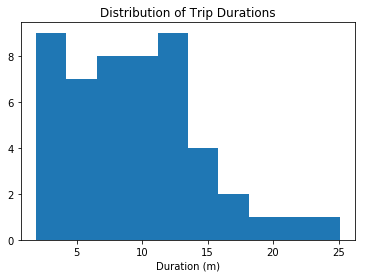

In [40]:
# load library
import matplotlib.pyplot as plt

# this is a 'magic word' that allows for plots to be displayed
# inline with the notebook. If you want to know more, see:
# http://ipython.readthedocs.io/en/stable/interactive/magics.html
%matplotlib inline 

# example histogram, data taken from bay area sample
data = [ 7.65,  8.92,  7.42,  5.50, 16.17,  4.20,  8.98,  9.62, 11.48, 14.33,
        19.02, 21.53,  3.90,  7.97,  2.62,  2.67,  3.08, 14.40, 12.90,  7.83,
        25.12,  8.30,  4.93, 12.43, 10.60,  6.17, 10.88,  4.78, 15.15,  3.53,
         9.43, 13.32, 11.72,  9.85,  5.22, 15.10,  3.95,  3.17,  8.78,  1.88,
         4.55, 12.68, 12.38,  9.78,  7.63,  6.45, 17.38, 11.90, 11.52,  8.63,]
plt.hist(data)
plt.title('Distribution of Trip Durations')
plt.xlabel('Duration (m)')
plt.show()

The above cell is a collection of fifty trip times in a list. This list was passed as the first argument to the `.hist()` function. This function performs the computations and creates plotting objects for generating a histogram, but the plot is actually not rendered until the `.show()` function is executed. The `.title()` and `.xlabel()` functions provide some labeling for plot context.

I will now use these functions to create a histogram of the trip times for Washington. I won't separate the Subscribers and Customers for now: I will just collect all of the trip times and plot them.

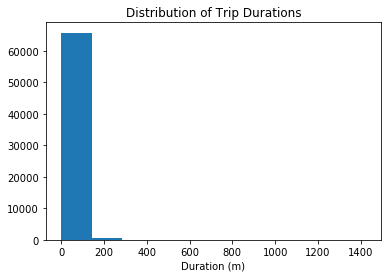

In [48]:

## use pyplot functions to generate a histogram of trip times.     ##

list_times = []

def list_of_times(filename):
    with open(filename) as fname:
        file_reader = csv.DictReader(fname)
        list_times = []
        for field in file_reader:
            list_times.append(float(field['duration']))
                              
    return list_times

#pprint(list_of_times('./examples/BayArea-Y3-Summary.csv'))
        
# for city in city_list:
#     print(list_of_times(city))

# example histogram, data taken from bay area sample
data1 = list_of_times('Washington-2016-Summary.csv')   
plt.hist(data1)
plt.title('Distribution of Trip Durations')
plt.xlabel('Duration (m)')
plt.show()


This plot is somewhat unexpected. The plot consists of one extremely tall bar on the left, a very short one next to it and a whole lot of empty space further to the right. The duration values on the x-axis suggests that there are some highly infrequent outliers in the data. Instead of reprocessing the data, I will use additional parameters with the `.hist()` function to limit the range of data that is plotted. Documentation for the function can be found [[here]](https://matplotlib.org/devdocs/api/_as_gen/matplotlib.pyplot.hist.html#matplotlib.pyplot.hist).

I will use the parameters of the `.hist()` function to plot the distribution of trip times for the Subscribers in my selected city. I will do the same thing for only the Customers. I will add limits to the plots so that only trips of duration less than 75 minutes are plotted. I will set the plots up so that bars are in five-minute wide intervals. I will use this to answer the following questions:

For each group, where is the peak of each distribution? How would you describe the shape of each distribution?


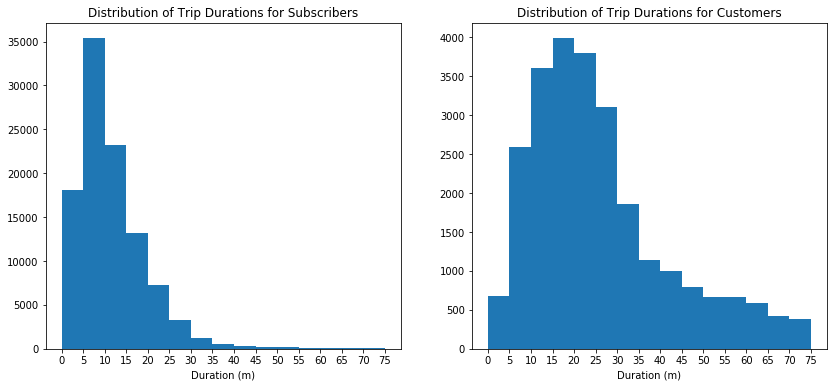

In [102]:
list_times1 = []
list_times2 = []

def list_of_times_split(filename):
    """
    This function takes as input a file containing, amongs other things, durations of trips.
    It creates two lists, one of Subscriber's trip durations and one of Customer's trip durations.
    These lists are then used to create histograms, one for Subscribers and one for Customers.
    
    """
  
    
    
    with open(filename) as fname:
        file_reader = csv.DictReader(fname)
        for field in file_reader:
            if field['user_type']=='Subscriber':
                
                list_times1.append(float(field['duration']))
            elif field['user_type'] == 'Customer':
                list_times2.append(float(field['duration']))
                
                              
    return (list_times1,list_times2)



data21 = list_of_times_split('./data/Washington-2016-Summary.csv')[0]   #'./data/Washington-2016-Summary.csv', './data/Chicago-2016-Summary.csv'
data22 = list_of_times_split('./data/Washington-2016-Summary.csv')[1]
plt.figure(figsize=(14, 6))
plt.subplot(1,2,1)
plt.hist(data21,range=(0,75),bins=15)
plt.title('Distribution of Trip Durations for Subscribers')
plt.xlabel('Duration (m)')
plt.xticks([0, 5, 10, 15, 20, 25, 30, 35, 40, 45, 50, 55, 60, 65, 70, 75])

plt.subplot(1,2,2)
plt.hist(data22,range=(0,75),bins=15)
plt.title('Distribution of Trip Durations for Customers')
plt.xlabel('Duration (m)')
plt.xticks([0, 5, 10, 15, 20, 25, 30, 35, 40, 45, 50, 55, 60, 65, 70, 75])
plt.show()
           
           

For the Subscribers histogram, the peak occurs at around 10 mins duration, using the Washington data. 
For the Customers histogram, the peak ooccurs at around 20 mins duration, using the Washington data. For both Subsribers and Customers the histogram leans to the left, with higher volumes being at the bottom of the chart - at shorter durations. It is also evident from the histograms that Subscribers has higher volumes than Customers.

<a id='eda_continued'></a>

## Continuing The Analysis

So far, I've performed an initial exploration into the data available. I have compared the relative volume of trips made between three U.S. cities and the ratio of trips made by Subscribers and Customers. For one of these cities, I have investigated differences between Subscribers and Customers in terms of how long a typical trip lasts. I will now look at the trend in volume of trips taken by Subscribers and Customers in each city during the week.



In [49]:
 
def days_of_week(filename):
    """
    This function takes as input a file and returns the number of trips taken by Subscribers
    and Customers each day of the week.
    
    
    """
    
    s_moncount = 0
    s_tuescount= 0
    s_wedcount = 0
    s_thurcount=0
    s_fricount=0
    s_satcount=0
    s_suncount=0
    
    c_moncount = 0
    c_tuescount= 0
    c_wedcount = 0
    c_thurcount=0
    c_fricount=0
    c_satcount=0
    c_suncount=0
    
    with open(filename) as filen:
        new_file_reader = csv.DictReader(filen)
        for line in new_file_reader:
            
            if line['user_type']=='Subscriber':
                
                if line['day_of_week']=='Monday':
                    s_moncount += 1
                elif line['day_of_week']=='Tuesday':
                    s_tuescount += 1
                elif line['day_of_week']=='Wednesday':
                    s_wedcount += 1
                elif line['day_of_week']=='Thursday':
                    s_thurcount += 1    
                 
                elif line['day_of_week']=='Friday':
                    s_fricount += 1   
                
                elif line['day_of_week']=='Saturday':
                    s_satcount += 1   
                
                elif line['day_of_week']=='Sunday':
                    s_suncount += 1   
                
                
            elif line['user_type']=='Customer':
                
                if line['day_of_week']=='Monday':
                    c_moncount +=1
                elif line['day_of_week']=='Tuesday':
                    c_tuescount += 1
                elif line['day_of_week']=='Wednesday':
                    c_wedcount += 1
                elif line['day_of_week']=='Thursday':
                    c_thurcount += 1    
                 
                elif line['day_of_week']=='Friday':
                    c_fricount += 1   
                
                elif line['day_of_week']=='Saturday':
                    c_satcount += 1   
                
                elif line['day_of_week']=='Sunday':
                    c_suncount += 1   
                    
        return (s_moncount,s_tuescount,s_wedcount,s_thurcount,s_fricount,s_satcount,s_suncount,c_moncount,c_tuescount,c_wedcount,c_thurcount,c_fricount,c_satcount,c_suncount)
         
print(days_of_week('Washington-2016-Summary.csv'))

(7658, 8322, 8520, 8454, 7958, 5589, 5252, 1736, 1426, 1583, 1530, 2012, 3311, 2975)


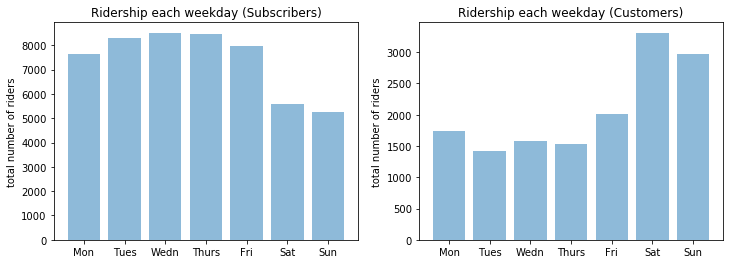

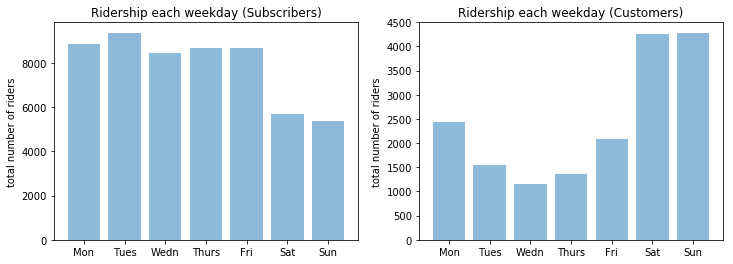

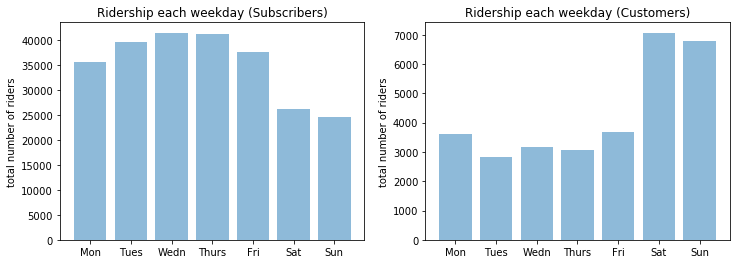

In [50]:
import numpy as np

def week_bargraph(filename):
    
    """
    This funtion creates two bargraphs showing the number of trips taken during the week by 
    Customers and Subscribers.
    
    """
    days = ['Mon', 'Tues', 'Wedn', 'Thurs','Fri','Sat','Sun']
    position_y = np.arange(len(days))
    s_day_vals = []
    c_day_vals = []
    values = days_of_week(filename)
    
    # creates list of volumes during week for Subscribers
    for x in range(0,7):
        s_day_vals.append(values[x])
        
    # creates list of volumes during week for Customers   
    for y in range(7,14):
        c_day_vals.append(values[y])
    

    plt.figure(figsize=(12, 4))
    
    plt.subplot(1,2,1)    
    plt.bar(position_y,s_day_vals,align = 'center', alpha = 0.5)
    plt.xticks(position_y,days)
    plt.ylabel('total number of riders')
    plt.title('Ridership each weekday (Subscribers)')
    
    
    plt.subplot(1,2,2)
    plt.bar(position_y,c_day_vals,align = 'center', alpha = 0.5)
    plt.xticks(position_y,days)
    plt.ylabel('total number of riders')
    plt.title('Ridership each weekday (Customers)')
    
for city in city_summary_files:
    
    week_bargraph(city)    
    

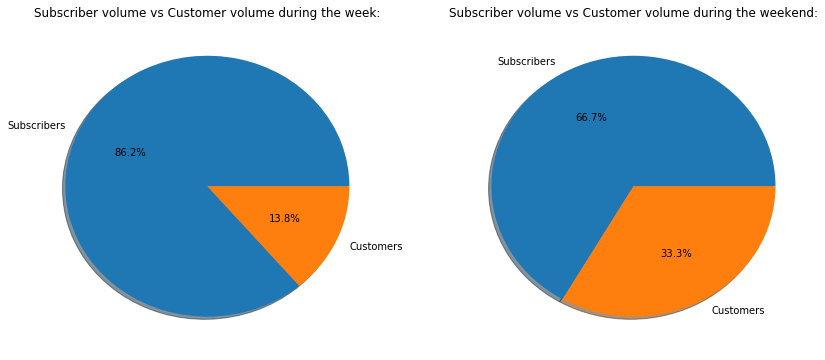

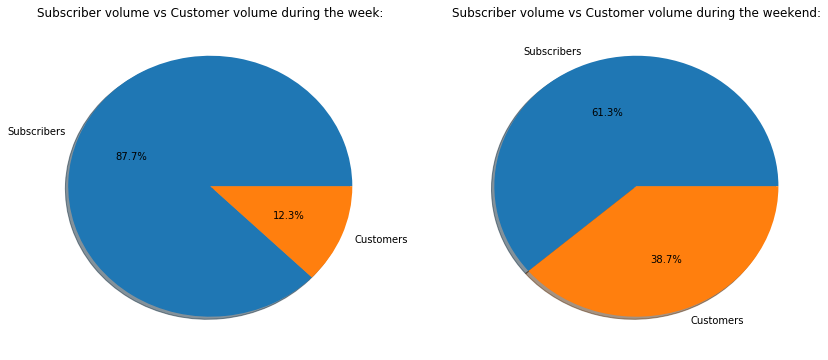

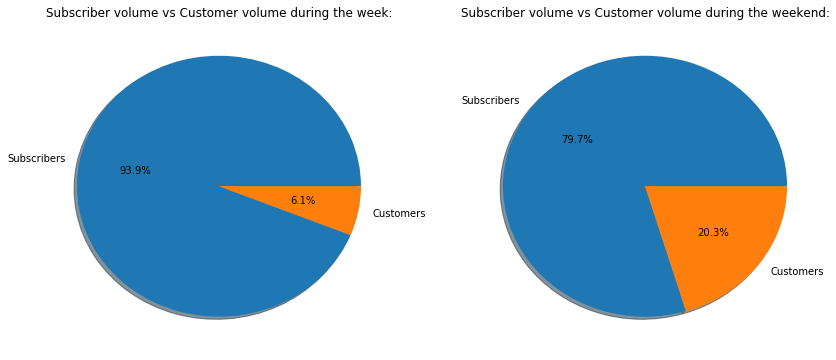

In [51]:
def weekend_piechart(filename):
    
    """
    This function creates a pie chart comparing the number of trips taken by Subscribers
    and Customers over the weekend
    
    """
    
    s_weekdays = 0
    c_weekdays = 0
    
    s_weekends=0
    c_weekends=0
    
    values = days_of_week(filename)
    
    # counts all volumes during weekdays for subscribers
    for i in range(0,5):
        
        s_weekdays += values[i]
        
    # counts all volumes during weekend for subscribers
        
    for j in range(5,8):
        s_weekends += values[j]
    
    # counts all volumes during weekdays for customers
    
    for k in range(8,12):
        c_weekdays += values[k]
     
    # counts all volumes during weekend for customers
    
    for l in range(12,14):
        c_weekends += values[l]
        
#     print ("s_weekdays",s_weekdays)
#     print ("s_weekends",s_weekends)
#     print ("c_weekdays",c_weekdays)
#     print ("c_weekends",c_weekends)

    #calculates subscriber volume percentage during weekdays
    swd_percentage = (s_weekdays/(s_weekdays+c_weekdays)*100)
    
    # calculates customer volume percentage during weekdays
    cwd_percentage = 100 - swd_percentage
    
    
    # calculates subscriber volume percentage during weekends
    swe_percentage = (s_weekends/(s_weekends+c_weekends)*100)
    
    # calculates customer volume percentage during weekends
    cwe_percentage = 100 - swe_percentage
    
    weekdays = [swd_percentage,cwd_percentage]
    weekends = [swe_percentage,cwe_percentage]
    labels = 'Subscribers','Customers'
    
    
    plt.figure(figsize=(14, 6))
    plt.subplot(1,2,1)    
    plt.pie(weekdays,labels=labels,autopct='%1.1f%%',shadow = True)
    plt.title('Subscriber volume vs Customer volume during the week:')
        
        
    plt.subplot(1,2,2)    
    plt.pie(weekends,labels=labels,autopct='%1.1f%%',shadow = True)
    plt.title('Subscriber volume vs Customer volume during the weekend:')
       
for city in city_summary_files:
    weekend_piechart(city)
        
        
    
    
    
    
    
    
    

In my analysis I looked at the trend in volume of trips taken by Subsribers and Customers in each city during the week. I used bargraphs to do this. From the graphs one can see that the volume of trips taken by Subsribers is highest during the week and lowest on weekends. For Customers, on the other hand, trip volumes are highest over the weekend. <br>
I then used pie charts to compare the volume of Subsriber trips to the volume of Customers trips during the week and on weekends. From the charts, it is clear that the Subscriber volume is consistently higher than the Customer volume. However, over weekends, the increases.

<a id='conclusions'></a>
## Conclusion and Recommendations

This project served as an introduction and sampling of the data analysis process: from generating questions, wrangling the data, and to exploring the data. At this point in the data analysis process, one might want to draw conclusions about the data by performing a statistical test or fitting the data to a model for making predictions. There are also a lot of potential analyses that could be performed on the data which are not possible with only the data provided. For example, detailed location data has not been investigated. Where are the most commonly used docks? What are the most common routes? As another example, weather has potential to have a large impact on daily ridership. How much is ridership impacted when there is rain or snow? Are subscribers or customers affected more by changes in weather?

Similar techniques can be used on other datasets. For example one can use data from Yelp to see how reliable a user's review and rating is by comparing it to the average rating for a restuarant with many reviews/ratings. Also, determine number of ratings/reviews provided by each user and propotion of good and bad reviews provided by a user. Investigate which restuarants receive more ratings based on, for example, location of restuarant. Determine factors assosiated with high ratings based on reviews.
